These is a free-form notebook showing a terse example of model-selection. (maybe to be expanded to a session in the future)

Consider two models for a 2d surface density profile of a galaxy:

1) The Plummer Model surface density:

$\Sigma(R) = \frac{M_0 a^2}{\pi (a^2 + R^2)^2}$

2) An exponential profile:

$\Sigma(R) = \Sigma_0 e^{-R/a}$

If we treat these as surface densities, integrating to infinity elminiates the overall scaling factor, so they are 

$\Sigma(R) \propto \frac{a^2}{(a^2 + R^2)^2}$

$\Sigma(R) \propto  e^{-R/a}$

both of which have only a free scale parameter $a$

Now to make the problem a bit more realistic we allow the center to vary.  I.e.

$R^2 = (x-x_0)^2 + (y-y_0)^2$

where $x_0$ and $y_0$ are free parameters

In [1]:
import numpy as np
from scipy import special, stats

import nautilus
import sympy
import corner

from matplotlib import pyplot as plt

In [2]:
R, a, u, x = sympy.symbols('R a u x', real=True, positive=True)

plummer = a**2/(a**2 + R**2)**2
N = sympy.integrate(plummer*R, (R, 0, sympy.oo)).simplify()
plummerN = plummer/N

sympy.solve(sympy.integrate(plummerN*R, (R, 0, x)).simplify() - u, x)[0]

-a*sqrt(u)*sqrt(-1/(u - 1))

In [3]:
sympy.integrate(plummerN*R, (R, 0, x)).simplify() 

x**2/(a**2 + x**2)

In [4]:
expp = sympy.exp(-R/a)
N = sympy.integrate(expp*R, (R, 0, sympy.oo)).simplify()
exppN = expp/N

sympy.solve(sympy.integrate(exppN*R, (R, 0, x)).simplify() - u, x)[0]

a*(-LambertW((u - 1)*exp(-1)) - 1)

In [5]:
plummerhlr = sympy.solve(sympy.integrate(plummerN*R, (R, 0, x)).simplify() - sympy.Rational(1,2), x)[0]
plummerhlr

a

In [6]:
exphlr = sympy.solve(sympy.integrate(exppN*R, (R, 0, x)).simplify() - sympy.Rational(1,2), x)[0]
exphlr

a*(-1 - LambertW(-exp(-1)/2, -1))

In [7]:
exphlr_scaling = float(exphlr.subs({a:1}).n())
exphlr_scaling

1.6783469900166605

In [8]:
-special.lambertw((.9999999999999-1)/np.exp(1), -1).real-1

np.float64(33.47348581349255)

In [9]:
def make_plummer(a, x0, y0, n):
    theta = np.random.uniform(0, 2*np.pi, n)
    u = np.random.uniform(0, 1, n)
    r = -a * np.sqrt(u) * np.sqrt(-1/(u-1))
    x = x0 + r * np.cos(theta)
    y = y0 + r * np.sin(theta)
    return np.array((x, y))

def make_exponential(a, x0, y0, n):
    theta = np.random.uniform(0, 2*np.pi, n)
    #r = np.random.exponential(a, n) # this is a *1D* exponential
    u = np.random.uniform(0, 1, n)
    r = -a*(special.lambertw((u-1)/np.exp(1), -1).real+1)
    x = x0 + r * np.cos(theta)
    y = y0 + r * np.sin(theta)
    return np.array((x, y))

(-5.0, 5.0)

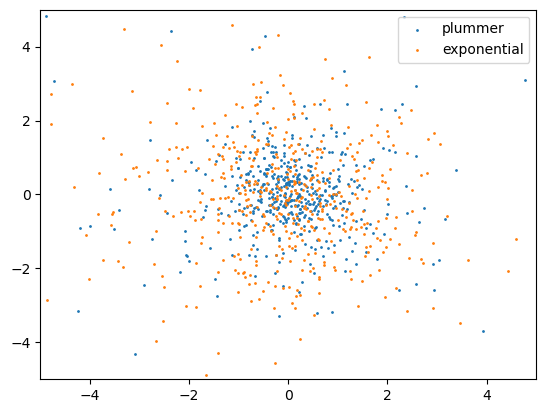

In [10]:
a_example = 1
n = 500

plt.scatter(*make_plummer(a_example, 0, 0, n), s=1, label='plummer')
plt.scatter(*make_exponential(a_example, 0, 0, n), s=1, label='exponential')
plt.legend()
plt.xlim(-5, 5)
plt.ylim(-5, 5)

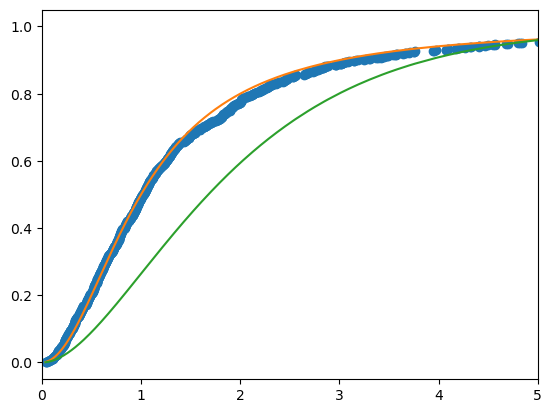

In [11]:
a_example = 1

r = np.sqrt(np.sum(make_plummer(a_example, 0, 0, 1000)**2, axis=0))
r = np.sort(r)
plt.scatter(r, np.arange(len(r))/len(r))
plt.xlim(0, 5)

plt.plot(r, r**2/(a_example**2 + r**2), c='C1') # plummer fit

expint = 1 - (a_example+r)*np.exp(-r/a_example)/a_example
plt.plot(r, expint, c='C2') # exponential fit

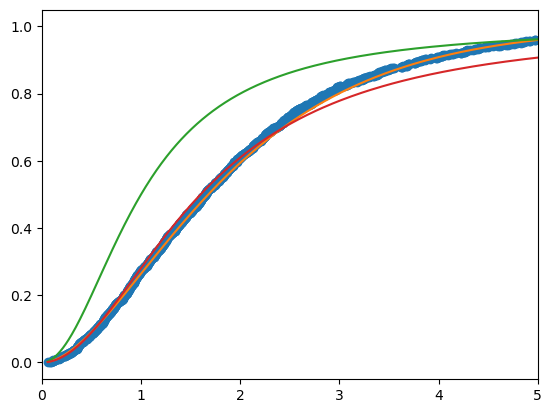

In [12]:
a_example = 1

r = np.sqrt(np.sum(make_exponential(a_example, 0, 0, 1000)**2, axis=0))
r = np.sort(r)
plt.scatter(r, np.arange(len(r))/len(r))
plt.xlim(0, 5)

expint = 1 - (a_example+r)*np.exp(-r/a_example)/a_example

plt.plot(r, expint, c='C1') # exponential
plt.plot(r, r**2/(a_example**2 + r**2), c='C2') #plummer same a
plt.plot(r, r**2/(1.6**2 + r**2), c='C3') #plummer by-eye a

It's clear from the by-eye fit that these profiles are quite different for the same a.

# Inference

Now try fitting examples.

In [13]:
n = 500
a = 1
x0 = y0 = 0

## Loguniform $a$ prior

In [14]:
priors = nautilus.Prior()
priors.add_parameter('a', stats.loguniform(0.1,10))
priors.add_parameter('x0', (-1,1))
priors.add_parameter('y0', (-1,1))

truths = [a, x0, y0]

In [15]:
plummerN

2*a**2/(R**2 + a**2)**2

Starting the nautilus sampler...
Please report issues at github.com/johannesulf/nautilus.
Status    | Bounds | Ellipses | Networks | Calls    | f_live | N_eff | log Z    
Finished  | 21     | 1        | 4        | 55300    | N/A    | 10045 | -645.06  


np.float64(-645.0577845415582)

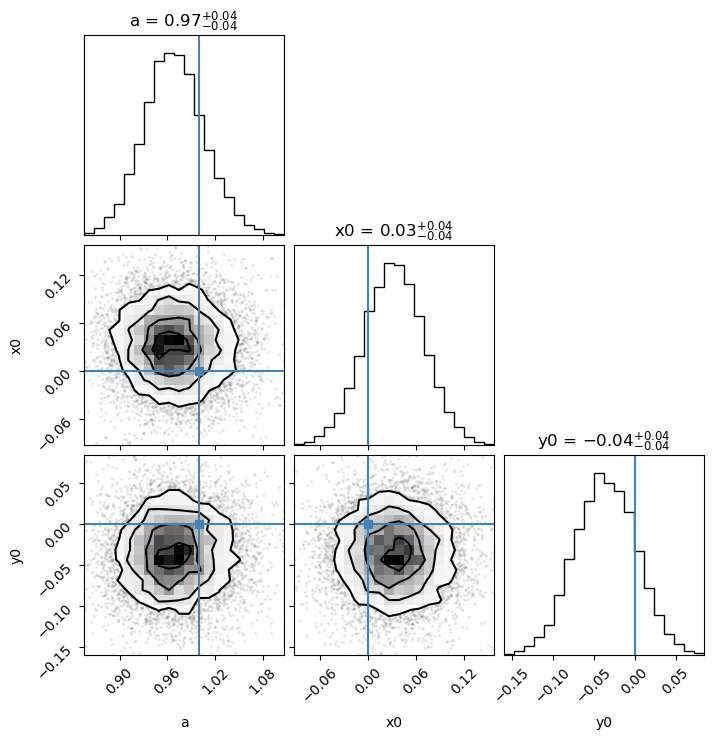

In [16]:
LOG2 = np.log(2)
def log_likelihood_plummer(params, data, ascaling=1):
    x, y = data

    r = np.sqrt((x - params['x0'])**2 + (y - params['y0'])**2)
    a = params['a']*ascaling
    logdens = 2*np.log(a) - 2*np.log(a**2 + r**2) + LOG2

    return np.sum(logdens)

data = make_plummer(*truths,n)
samplerplum = nautilus.Sampler(priors, log_likelihood_plummer, likelihood_kwargs={'data':data})
samplerplum.run(discard_exploration=True, verbose=True)

post, log_w, log_l = samplerplum.posterior(return_as_dict=True)
w = np.exp(log_w)
corner.corner(np.array([post[pnm] for pnm in priors.keys]).T, weights=w, truths=truths, labels=priors.keys, show_titles=True, range=[.999]*len(priors.keys))

samplerplum.log_z

In [17]:
exppN

exp(-R/a)/a**2

Starting the nautilus sampler...
Please report issues at github.com/johannesulf/nautilus.
Status    | Bounds | Ellipses | Networks | Calls    | f_live | N_eff | log Z    
Finished  | 20     | 1        | 4        | 53100    | N/A    | 10032 | -996.15  


np.float64(-996.1541577441897)

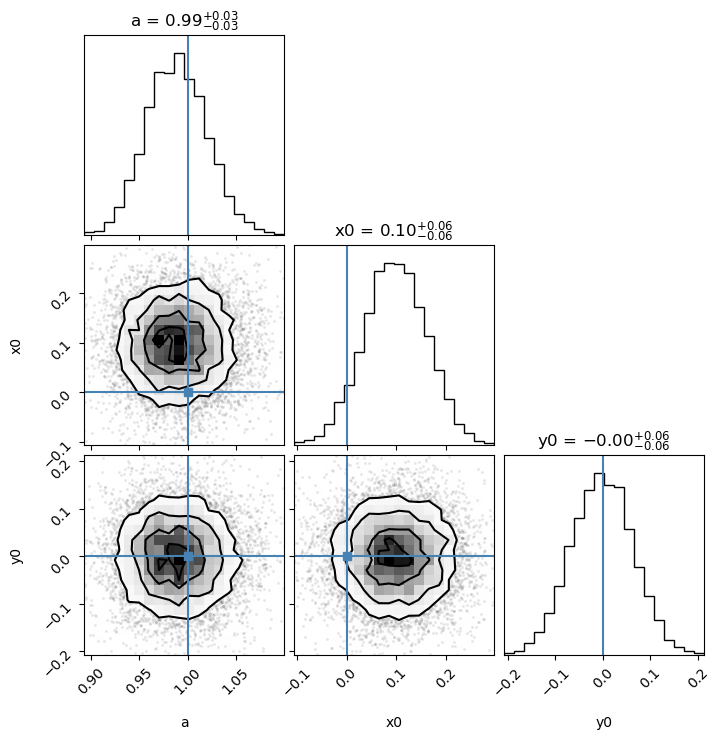

In [18]:
def log_likelihood_exp(params, data, ascaling=1):
    x, y = data

    r = np.sqrt((x - params['x0'])**2 + (y - params['y0'])**2)
    a = params['a']*ascaling
    logdens = -(r/a) - 2*np.log(a)

    return np.sum(logdens)

data = make_exponential(*truths,n)
samplerexp = nautilus.Sampler(priors, log_likelihood_exp, likelihood_kwargs={'data':data})
samplerexp.run(discard_exploration=True, verbose=True)

post, log_w, log_l = samplerexp.posterior(return_as_dict=True)
w = np.exp(log_w)
corner.corner(np.array([post[pnm] for pnm in priors.keys]).T, weights=w, truths=truths, labels=priors.keys, show_titles=True, range=[.999]*len(priors.keys))

samplerexp.log_z

In [19]:
(samplerplum.log_z - samplerexp.log_z)/np.log(10)

np.float64(152.47921749814753)

# Sampling from the "Wrong" distribution

Now try sampling on a mis-matched dataset by trying each with "true" datasets from each.

In [20]:
def infer_both(dataxy, priors, truths, verbose=True, pool=None, ascaling=(1, 1)):
    samplerplum = nautilus.Sampler(priors, log_likelihood_plummer, likelihood_kwargs={'data':dataxy, 'ascaling':ascaling[0]}, pool=pool)
    samplerplum.run(discard_exploration=True, verbose=verbose)

    samplerexp = nautilus.Sampler(priors, log_likelihood_exp, likelihood_kwargs={'data':dataxy, 'ascaling':ascaling[1]}, pool=pool)
    samplerexp.run(discard_exploration=True, verbose=verbose)


    post, log_w, _ = samplerplum.posterior(return_as_dict=True)
    figplum = corner.corner(np.array([post[pnm] for pnm in priors.keys]).T, weights=np.exp(log_w), truths=truths, labels=priors.keys, show_titles=True, range=[.999]*len(priors.keys))

    post, log_w, _ = samplerexp.posterior(return_as_dict=True)
    figexp = corner.corner(np.array([post[pnm] for pnm in priors.keys]).T, weights=np.exp(log_w), truths=truths, labels=priors.keys, show_titles=True, range=[.999]*len(priors.keys))

    return samplerplum, samplerexp, figplum, figexp

In [21]:
n = 500
a = 1
x0 = y0 = 0
truths = [a, x0, y0]

priors = nautilus.Prior()
priors.add_parameter('a', stats.loguniform(0.1,10))
priors.add_parameter('x0', (-1,1))
priors.add_parameter('y0', (-1,1))

Starting the nautilus sampler...
Please report issues at github.com/johannesulf/nautilus.
Status    | Bounds | Ellipses | Networks | Calls    | f_live | N_eff | log Z    
Finished  | 21     | 1        | 4        | 55952    | N/A    | 10069 | -646.42  
Starting the nautilus sampler...
Please report issues at github.com/johannesulf/nautilus.
Status    | Bounds | Ellipses | Networks | Calls    | f_live | N_eff | log Z    
Finished  | 21     | 1        | 4        | 55536    | N/A    | 10082 | -726.73  


np.float64(34.876818642372484)

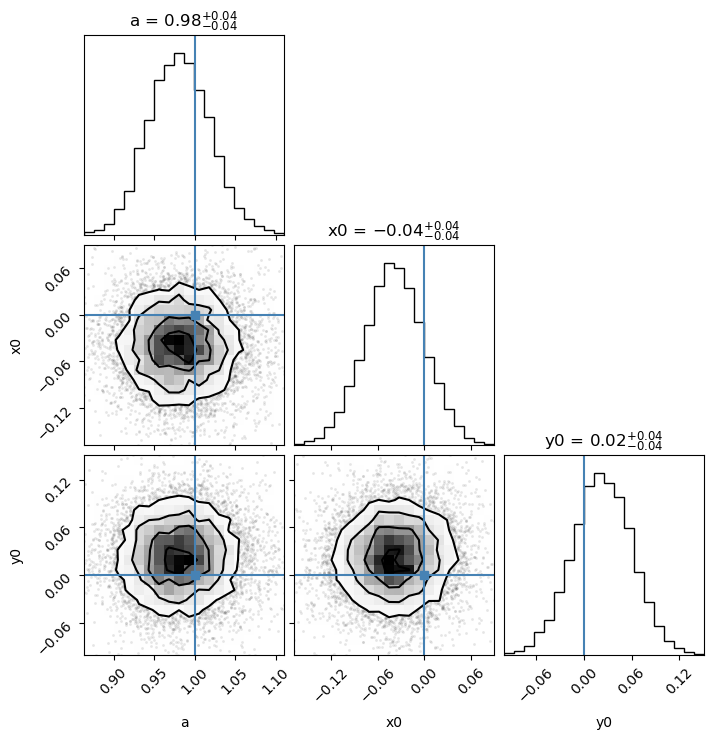

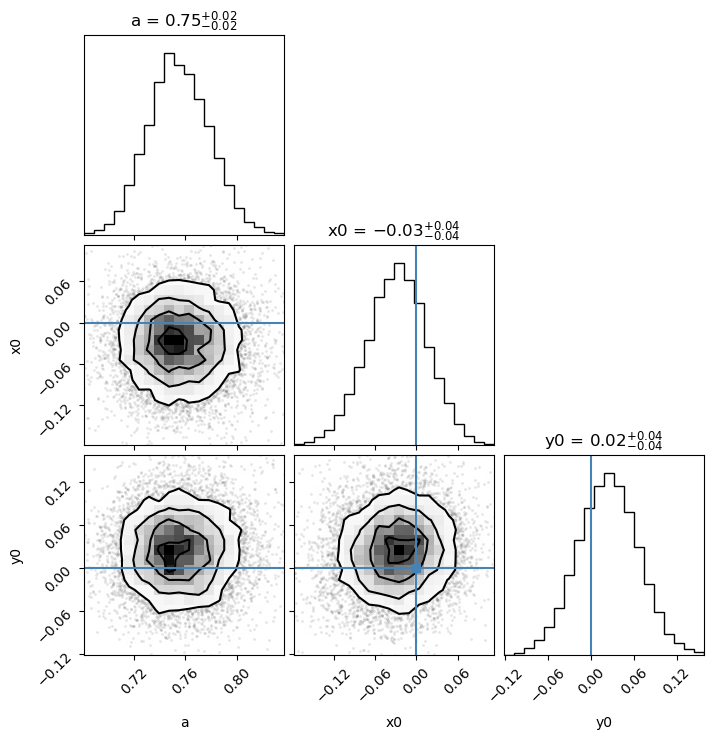

In [22]:
plumdata = make_plummer(*truths, n)
samplerplum_plumdata, samplerexp_plumdata, _, _ = infer_both(plumdata, priors, truths, pool=8)

(samplerplum_plumdata.log_z - samplerexp_plumdata.log_z)/np.log(10)

Starting the nautilus sampler...
Please report issues at github.com/johannesulf/nautilus.
Status    | Bounds | Ellipses | Networks | Calls    | f_live | N_eff | log Z    
Finished  | 19     | 1        | 4        | 52104    | N/A    | 10046 | -1068.49 
Starting the nautilus sampler...
Please report issues at github.com/johannesulf/nautilus.
Status    | Bounds | Ellipses | Networks | Calls    | f_live | N_eff | log Z    
Finished  | 19     | 1        | 4        | 53144    | N/A    | 10061 | -1038.78 


np.float64(-12.905168547366035)

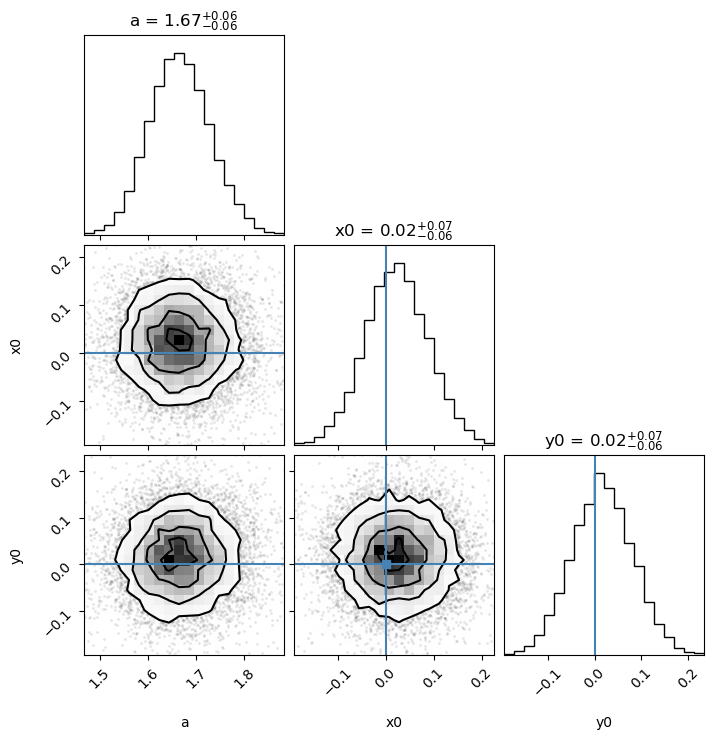

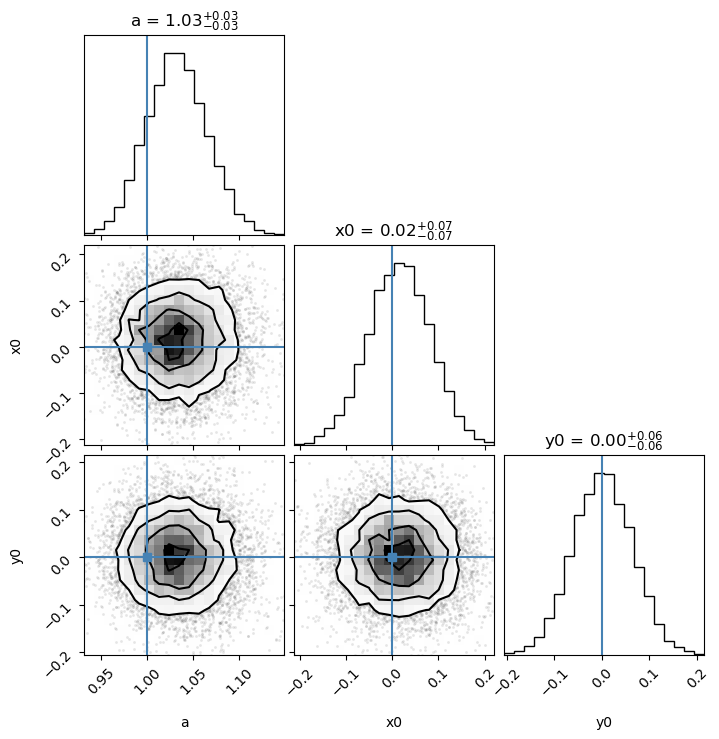

In [23]:
expdata = make_exponential(*truths, n)
samplerplum_expdata, samplerexp_expdata, _, _ = infer_both(expdata, priors, truths, pool=8)

(samplerplum_expdata.log_z - samplerexp_expdata.log_z)/np.log(10)

As expected, the two plummer model is preferred in the plummer-sampled case, and exp in exp.  Does this depend at all on the a-scaling effect?

Starting the nautilus sampler...
Please report issues at github.com/johannesulf/nautilus.
Status    | Bounds | Ellipses | Networks | Calls    | f_live | N_eff | log Z    
Finished  | 20     | 1        | 4        | 55224    | N/A    | 10029 | -623.22  
Starting the nautilus sampler...
Please report issues at github.com/johannesulf/nautilus.
Status    | Bounds | Ellipses | Networks | Calls    | f_live | N_eff | log Z    
Finished  | 20     | 1        | 4        | 55224    | N/A    | 10049 | -685.70  


np.float64(27.134277110707675)

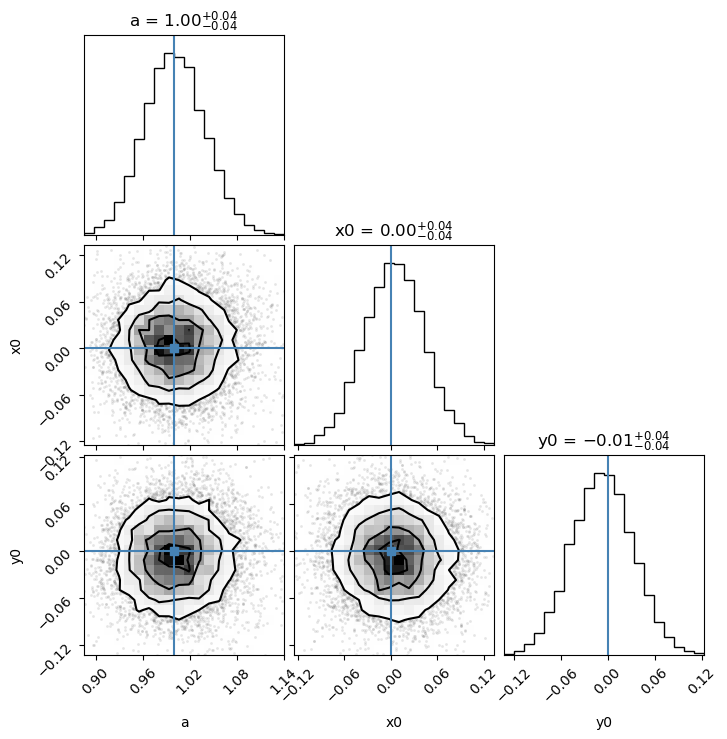

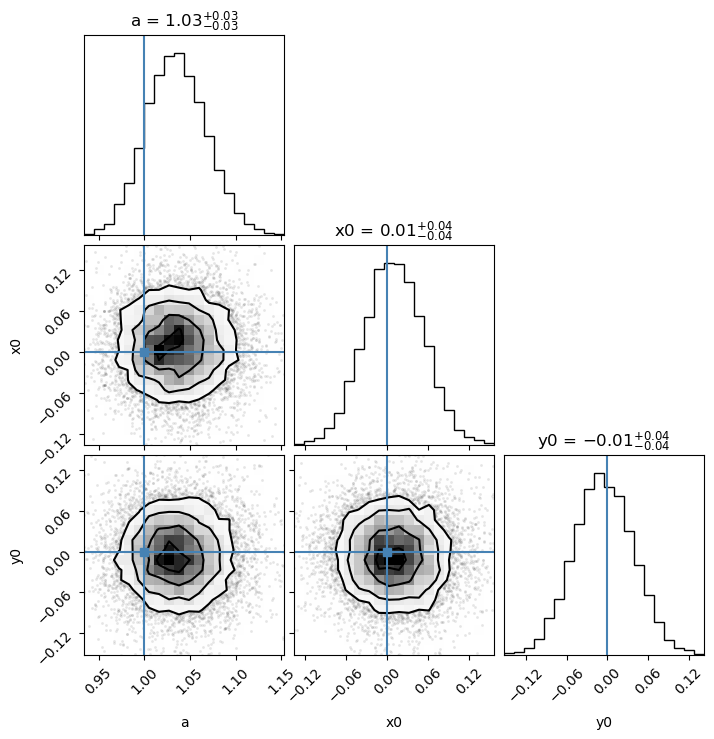

In [ ]:
plumdata = make_plummer(*truths, n)
samplerplum_plumdata, samplerexp_plumdata, _, _ = infer_both(plumdata, priors, truths, pool=8, ascaling=(1, .7))

(samplerplum_plumdata.log_z - samplerexp_plumdata.log_z)/np.log(10)

Starting the nautilus sampler...
Please report issues at github.com/johannesulf/nautilus.
Status    | Bounds | Ellipses | Networks | Calls    | f_live | N_eff | log Z    
Finished  | 19     | 1        | 4        | 52312    | N/A    | 10083 | -1034.46 
Starting the nautilus sampler...
Please report issues at github.com/johannesulf/nautilus.
Status    | Bounds | Ellipses | Networks | Calls    | f_live | N_eff | log Z    
Finished  | 19     | 1        | 4        | 53144    | N/A    | 10073 | -1011.63 


np.float64(-9.915442035733914)

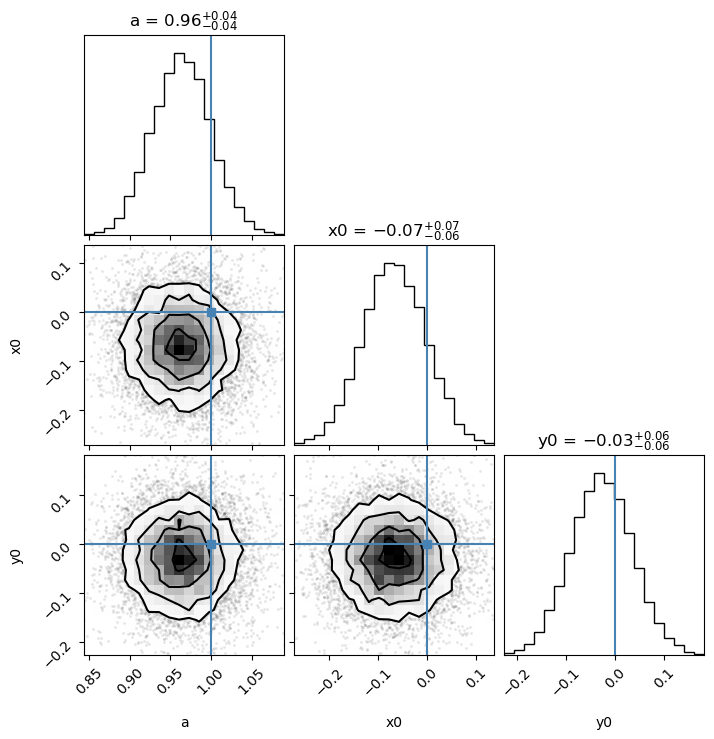

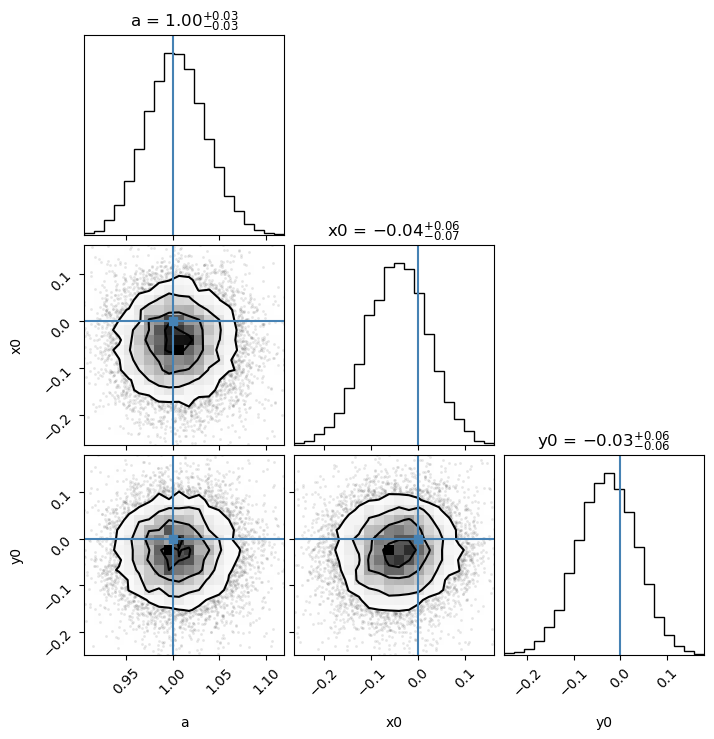

In [25]:
expdata = make_exponential(*truths, n)
samplerplum_expdata, samplerexp_expdata, _, _ = infer_both(expdata, priors, truths, pool=8, ascaling=(exphlr_scaling, 1))

(samplerplum_expdata.log_z - samplerexp_expdata.log_z)/np.log(10)

Nope, not at all, because $a$ is pretty well-measured.

## Uniform a prior

In [32]:
priors2 = nautilus.Prior()
priors2.add_parameter('a', (.1, 10))
priors2.add_parameter('x0', (-1,1))
priors2.add_parameter('y0', (-1,1))

Starting the nautilus sampler...
Please report issues at github.com/johannesulf/nautilus.
Status    | Bounds | Ellipses | Networks | Calls    | f_live | N_eff | log Z    
Finished  | 21     | 1        | 4        | 56784    | N/A    | 10044 | -782.61  
Starting the nautilus sampler...
Please report issues at github.com/johannesulf/nautilus.
Status    | Bounds | Ellipses | Networks | Calls    | f_live | N_eff | log Z    
Finished  | 22     | 1        | 4        | 57616    | N/A    | 10043 | -893.97  


np.float64(48.36345462752649)

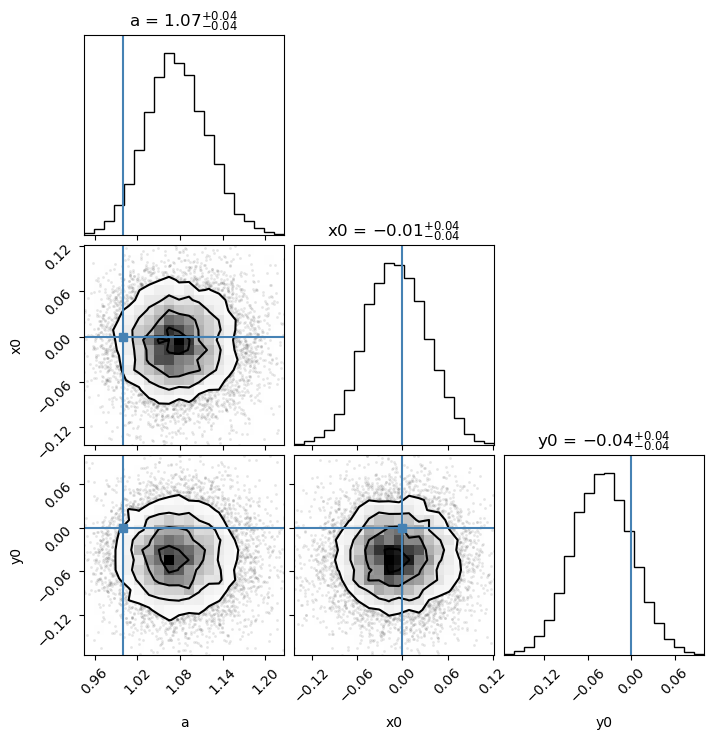

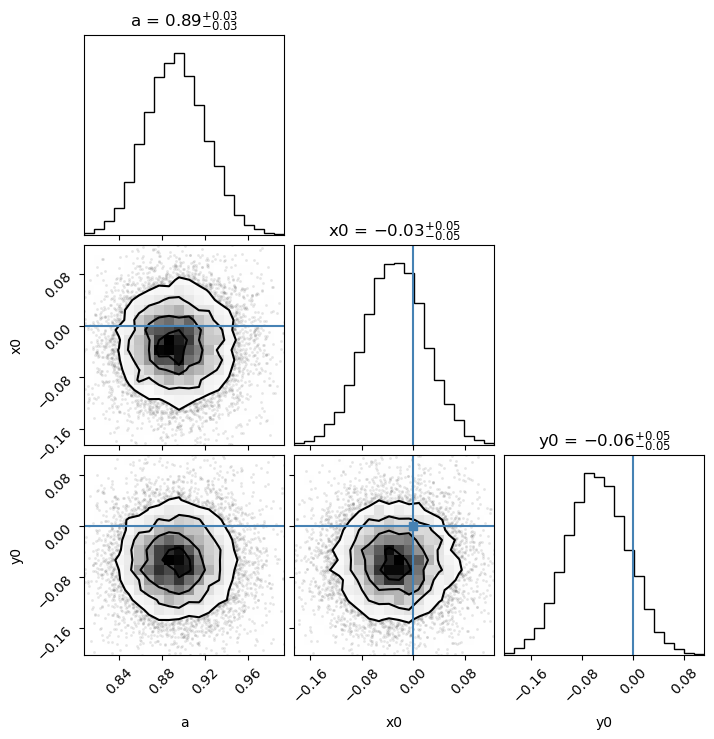

In [42]:
plumdata = make_plummer(*truths, n)
samplerplum_plumdata, samplerexp_plumdata, _, _ = infer_both(plumdata, priors2, truths, pool=8)

(samplerplum_plumdata.log_z - samplerexp_plumdata.log_z)/np.log(10)

Starting the nautilus sampler...
Please report issues at github.com/johannesulf/nautilus.
Status    | Bounds | Ellipses | Networks | Calls    | f_live | N_eff | log Z    
Finished  | 19     | 1        | 4        | 52936    | N/A    | 10042 | -1048.29 
Starting the nautilus sampler...
Please report issues at github.com/johannesulf/nautilus.
Status    | Bounds | Ellipses | Networks | Calls    | f_live | N_eff | log Z    
Finished  | 20     | 1        | 4        | 55224    | N/A    | 10063 | -1029.55 


np.float64(-8.140554976650462)

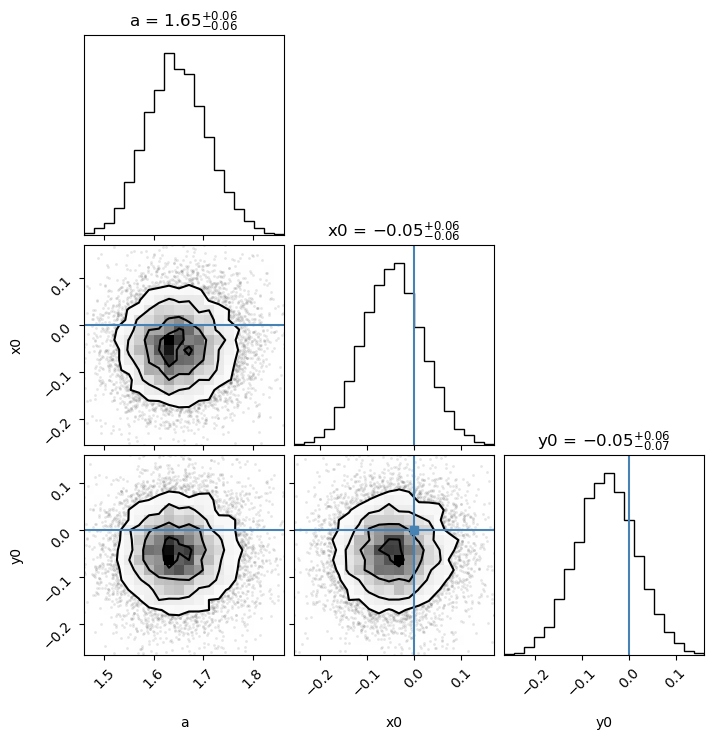

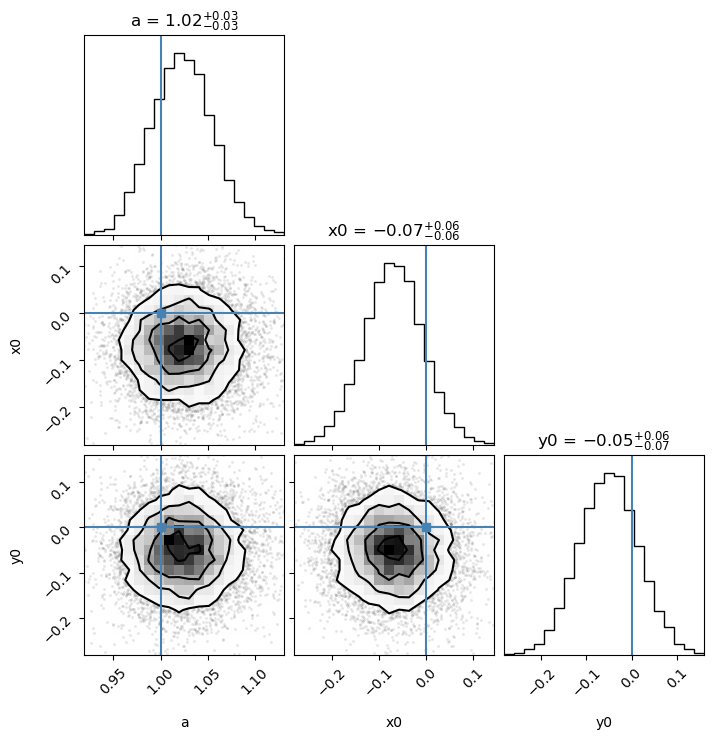

In [34]:
expdata = make_exponential(*truths, n)
samplerplum_expdata, samplerexp_expdata, _, _ = infer_both(expdata, priors2, truths, pool=8)

(samplerplum_expdata.log_z - samplerexp_expdata.log_z)/np.log(10)

Same result, because $a$ is so well localized anyway, although the magnitude is quite different. What if we do a-scaling?


Starting the nautilus sampler...
Please report issues at github.com/johannesulf/nautilus.
Status    | Bounds | Ellipses | Networks | Calls    | f_live | N_eff | log Z    
Finished  | 22     | 1        | 4        | 57600    | N/A    | 10088 | -653.76  
Starting the nautilus sampler...
Please report issues at github.com/johannesulf/nautilus.
Status    | Bounds | Ellipses | Networks | Calls    | f_live | N_eff | log Z    
Finished  | 22     | 1        | 4        | 57100    | N/A    | 10074 | -761.07  


np.float64(46.605591311791486)

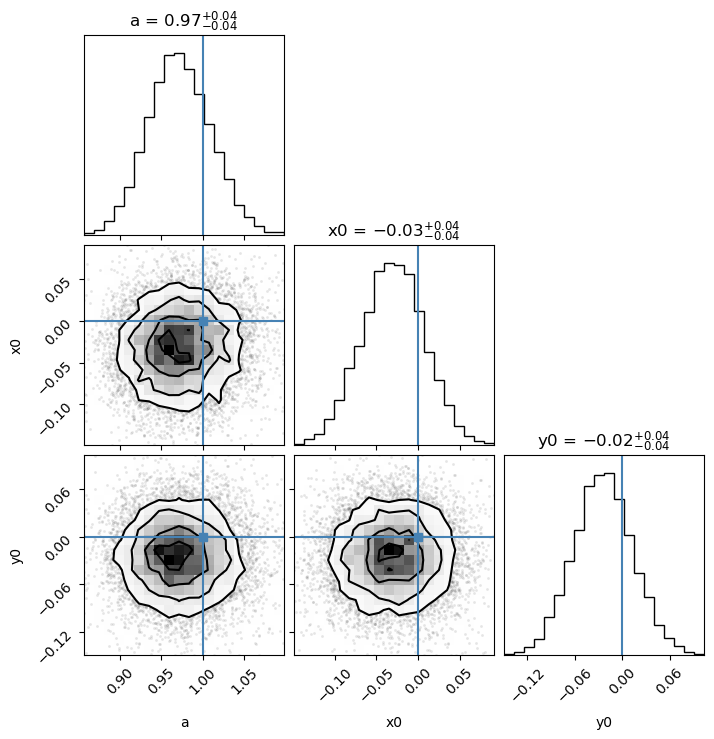

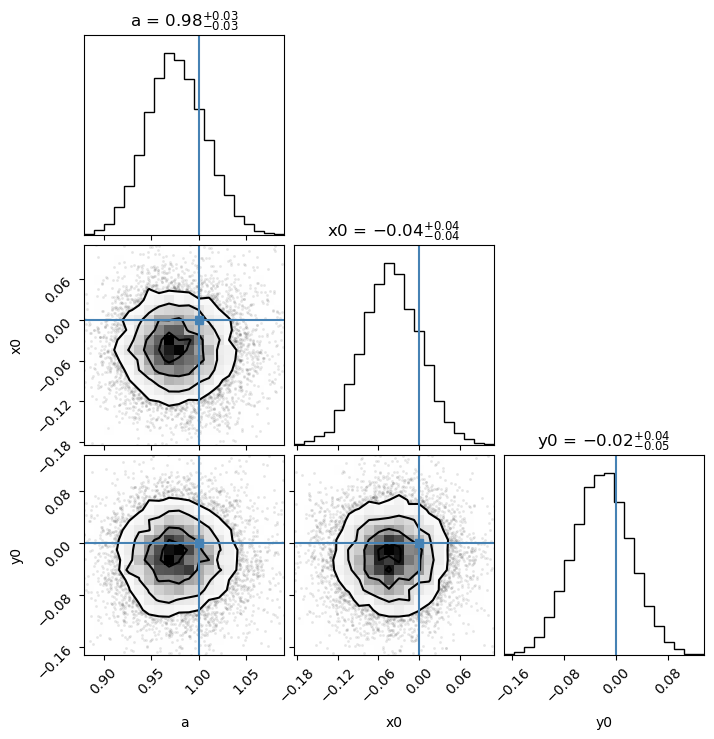

In [53]:
plumdata = make_plummer(*truths, n)
samplerplum_plumdata, samplerexp_plumdata, _, _ = infer_both(plumdata, priors2, truths, pool=4, ascaling=(1, .8))

(samplerplum_plumdata.log_z - samplerexp_plumdata.log_z)/np.log(10)

Starting the nautilus sampler...
Please report issues at github.com/johannesulf/nautilus.
Status    | Bounds | Ellipses | Networks | Calls    | f_live | N_eff | log Z    
Finished  | 21     | 1        | 4        | 55536    | N/A    | 10092 | -999.94  
Starting the nautilus sampler...
Please report issues at github.com/johannesulf/nautilus.
Status    | Bounds | Ellipses | Networks | Calls    | f_live | N_eff | log Z    
Finished  | 20     | 1        | 4        | 55328    | N/A    | 10099 | -979.78  


np.float64(-8.754989134210597)

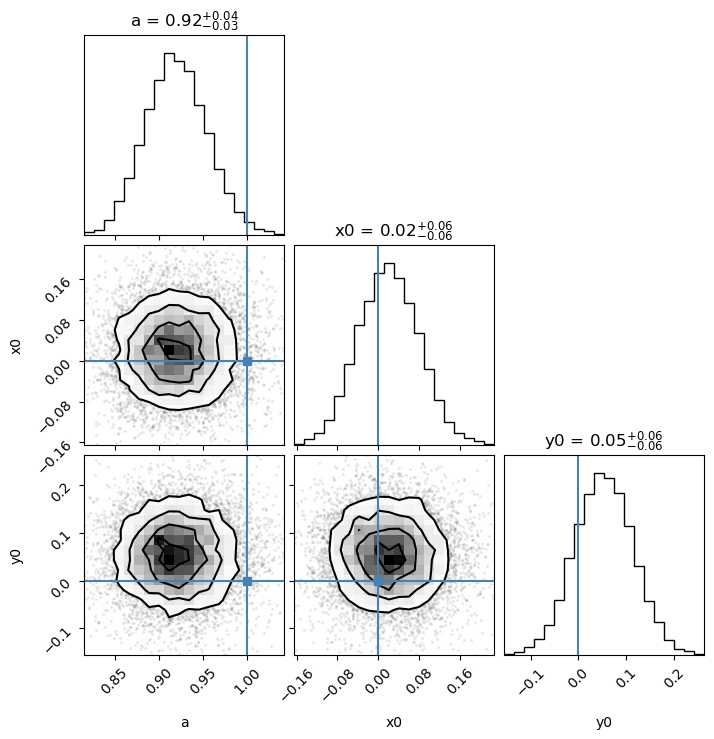

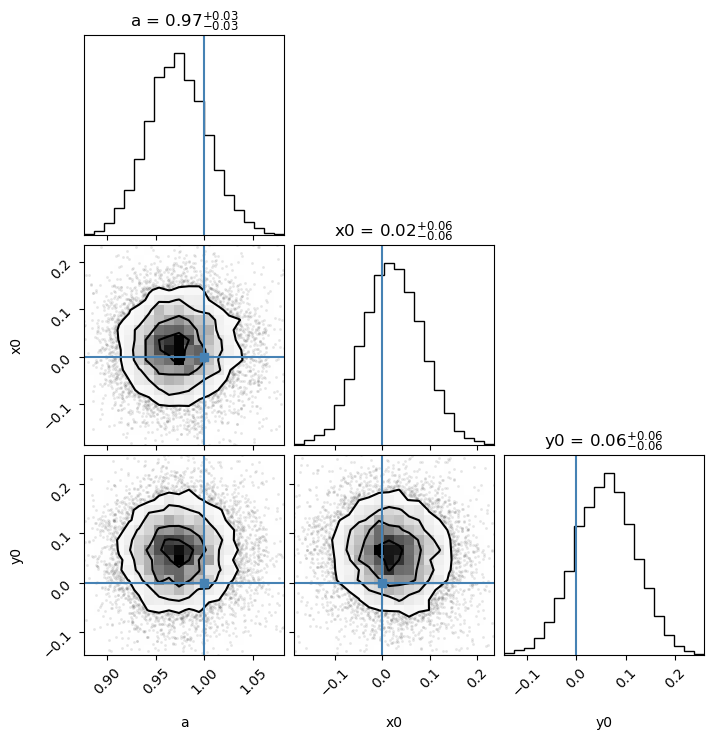

In [41]:
expdata = make_exponential(*truths, n)
samplerplum_expdata, samplerexp_expdata, _, _ = infer_both(expdata, priors2, truths, pool=8, ascaling=(exphlr_scaling, 1))

(samplerplum_expdata.log_z - samplerexp_expdata.log_z)/np.log(10)


## Strong $a$ prior

What happens when we force $a$ to be close to the "right" answer?  (Now definitely need the a-scaling)

In [24]:
priors3 = nautilus.Prior()
priors3.add_parameter('a', (.99, 1.01))
priors3.add_parameter('x0', (-1,1))
priors3.add_parameter('y0', (-1,1))

Starting the nautilus sampler...
Please report issues at github.com/johannesulf/nautilus.
Status    | Bounds | Ellipses | Networks | Calls    | f_live | N_eff | log Z    
Finished  | 16     | 1        | 4        | 44700    | N/A    | 10005 | -587.57  
Starting the nautilus sampler...
Please report issues at github.com/johannesulf/nautilus.
Status    | Bounds | Ellipses | Networks | Calls    | f_live | N_eff | log Z    
Finished  | 17     | 1        | 4        | 46400    | N/A    | 10065 | -630.38  


np.float64(18.59317609186373)

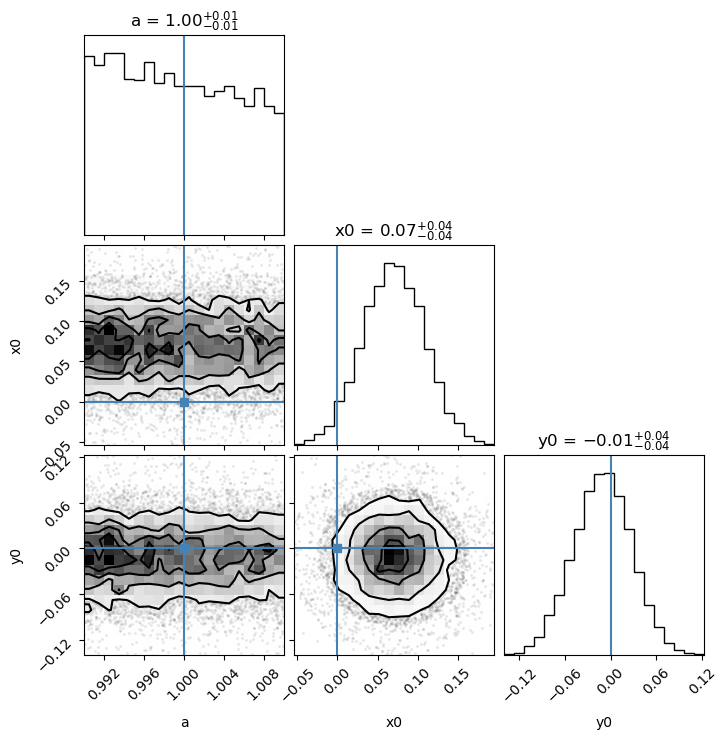

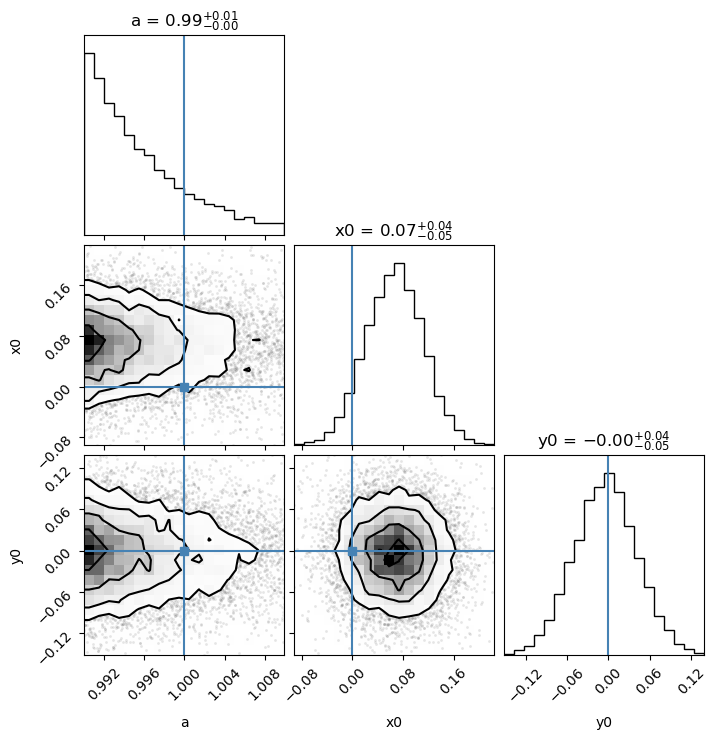

In [25]:
plumdata = make_plummer(*truths, n)
samplerplum_plumdata, samplerexp_plumdata, _, _ = infer_both(plumdata, priors3, truths, pool=4, ascaling=(1, .8))

(samplerplum_plumdata.log_z - samplerexp_plumdata.log_z)/np.log(10)

Starting the nautilus sampler...
Please report issues at github.com/johannesulf/nautilus.
Status    | Bounds | Ellipses | Networks | Calls    | f_live | N_eff | log Z    
Finished  | 15     | 1        | 4        | 42500    | N/A    | 10060 | -1012.33 
Starting the nautilus sampler...
Please report issues at github.com/johannesulf/nautilus.
Status    | Bounds | Ellipses | Networks | Calls    | f_live | N_eff | log Z    
Finished  | 14     | 1        | 4        | 42000    | N/A    | 10080 | -989.84  


np.float64(-9.766880988139588)

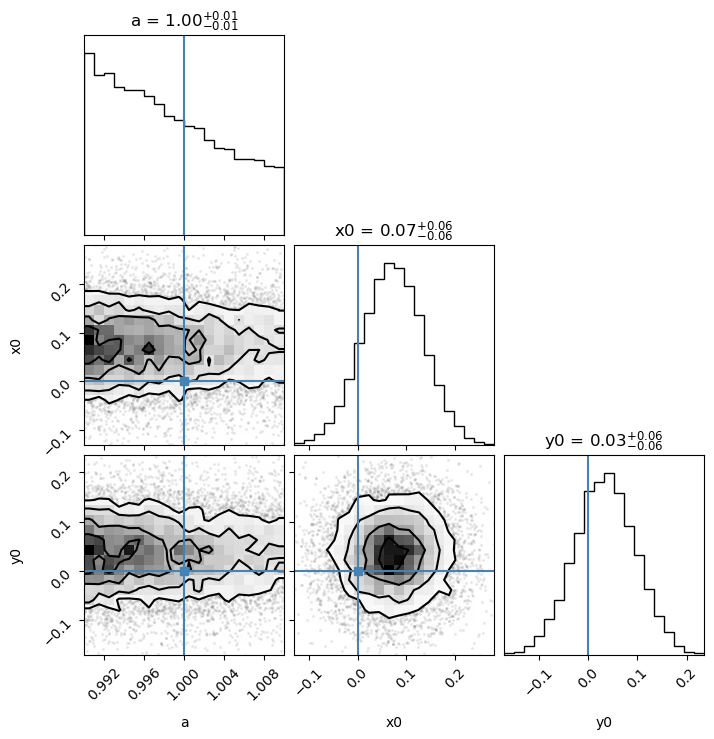

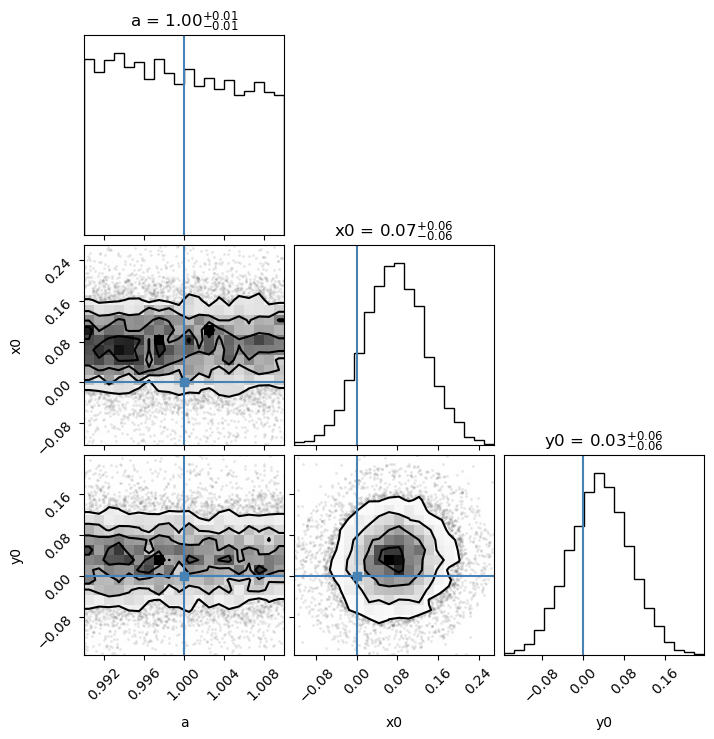

In [26]:
expdata = make_exponential(*truths, n)
samplerplum_expdata, samplerexp_expdata, _, _ = infer_both(expdata, priors3, truths, pool=4, ascaling=(exphlr_scaling, 1))

(samplerplum_expdata.log_z - samplerexp_expdata.log_z)/np.log(10)

## What if you use the *wrong* normalization?

Lets pretend we forgot the factor-of-2 in the plummer:

Starting the nautilus sampler...
Please report issues at github.com/johannesulf/nautilus.
Status    | Bounds | Ellipses | Networks | Calls    | f_live | N_eff | log Z    
Finished  | 21     | 1        | 4        | 55300    | N/A    | 10061 | -467.25  
Starting the nautilus sampler...
Please report issues at github.com/johannesulf/nautilus.
Status    | Bounds | Ellipses | Networks | Calls    | f_live | N_eff | log Z    
Finished  | 21     | 1        | 4        | 55100    | N/A    | 10035 | -697.63  
Starting the nautilus sampler...
Please report issues at github.com/johannesulf/nautilus.
Status    | Bounds | Ellipses | Networks | Calls    | f_live | N_eff | log Z    
Finished  | 21     | 1        | 4        | 55600    | N/A    | 10029 | -620.68  
Starting the nautilus sampler...
Please report issues at github.com/johannesulf/nautilus.
Status    | Bounds | Ellipses | Networks | Calls    | f_live | N_eff | log Z    
Finished  | 21     | 1        | 4        | 55200    | N/A    | 10001 | -6

(np.float64(100.05528822128227), np.float64(33.421069643060726))

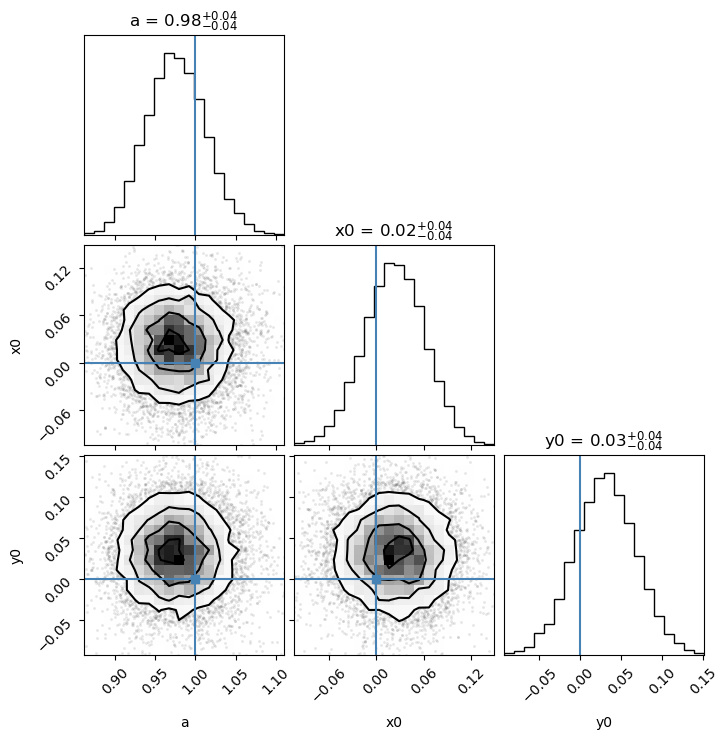

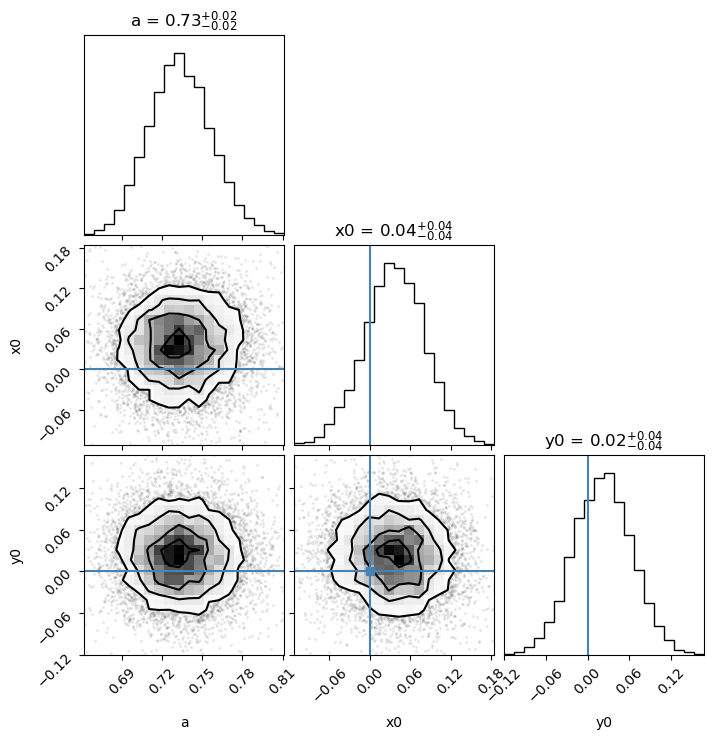

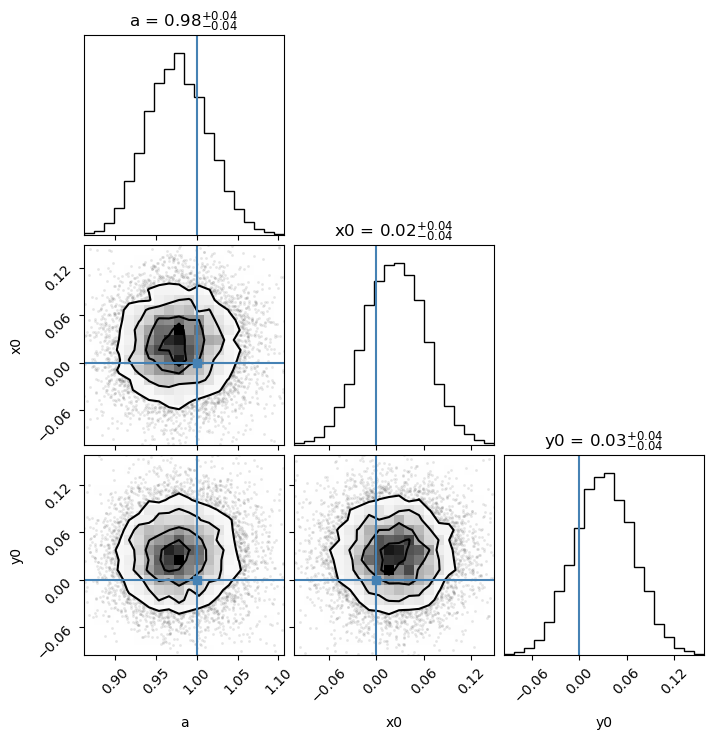

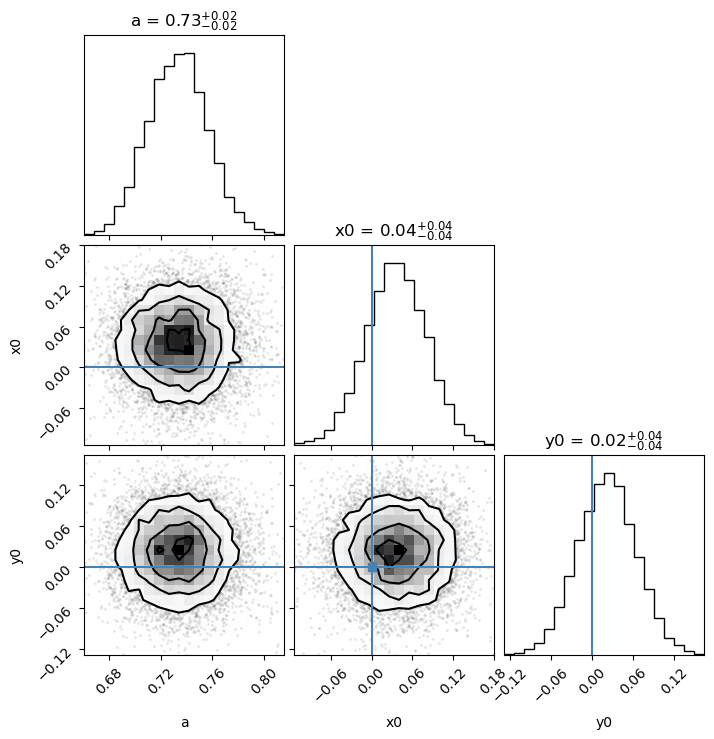

In [23]:
plumdata = make_plummer(*truths, n)

LOG2 = 1

samplerplum_plumdata, samplerexp_plumdata, _, _ = infer_both(plumdata, priors, truths, pool=4)
bf1 = (samplerplum_plumdata.log_z - samplerexp_plumdata.log_z)/np.log(10)

LOG2 = np.log(2)

samplerplum_plumdata, samplerexp_plumdata, _, _ = infer_both(plumdata, priors, truths, pool=4)
bf2 = (samplerplum_plumdata.log_z - samplerexp_plumdata.log_z)/np.log(10)


bf1, bf2 

Starting the nautilus sampler...
Please report issues at github.com/johannesulf/nautilus.
Status    | Bounds | Ellipses | Networks | Calls    | f_live | N_eff | log Z    
Finished  | 19     | 1        | 4        | 52500    | N/A    | 10056 | -848.97  
Starting the nautilus sampler...
Please report issues at github.com/johannesulf/nautilus.
Status    | Bounds | Ellipses | Networks | Calls    | f_live | N_eff | log Z    
Finished  | 20     | 1        | 4        | 53100    | N/A    | 10037 | -981.78  
Starting the nautilus sampler...
Please report issues at github.com/johannesulf/nautilus.
Status    | Bounds | Ellipses | Networks | Calls    | f_live | N_eff | log Z    
Finished  | 20     | 1        | 4        | 52800    | N/A    | 10066 | -1002.38 
Starting the nautilus sampler...
Please report issues at github.com/johannesulf/nautilus.
Status    | Bounds | Ellipses | Networks | Calls    | f_live | N_eff | log Z    
Finished  | 20     | 1        | 4        | 53500    | N/A    | 10014 | -9

(np.float64(57.67851177461837), np.float64(-8.938181771217653))

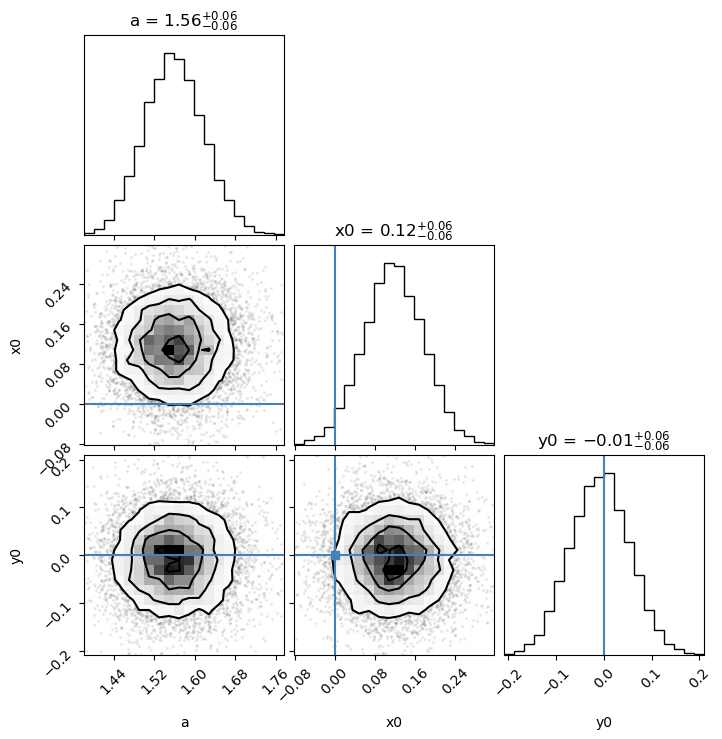

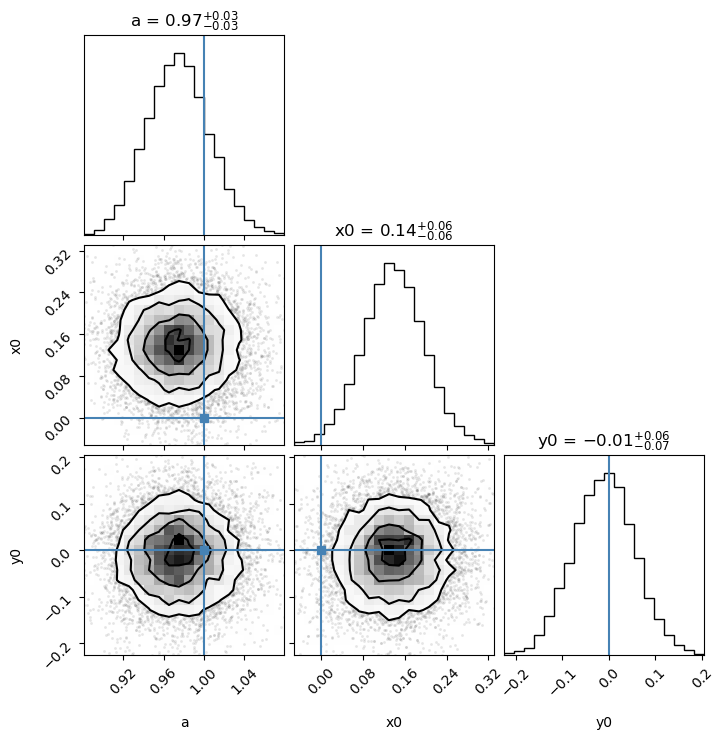

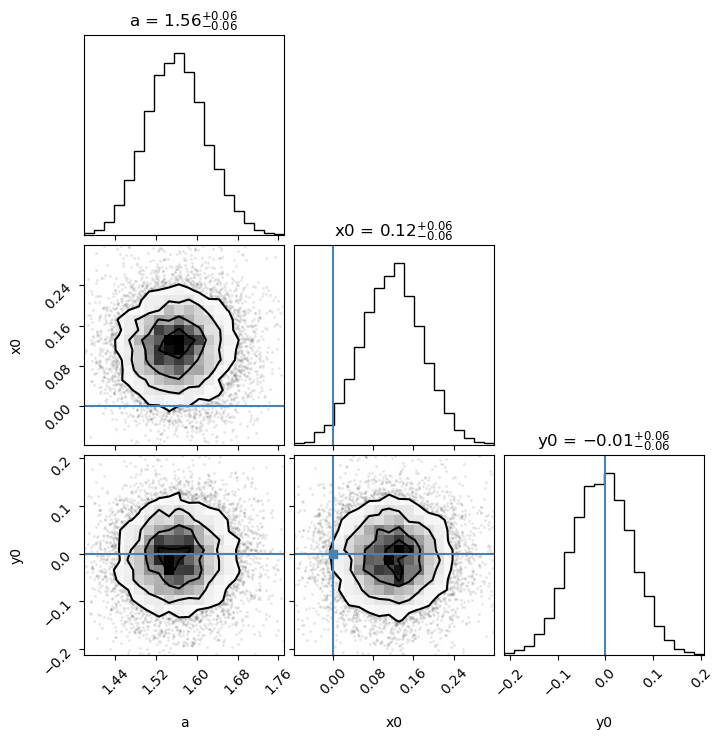

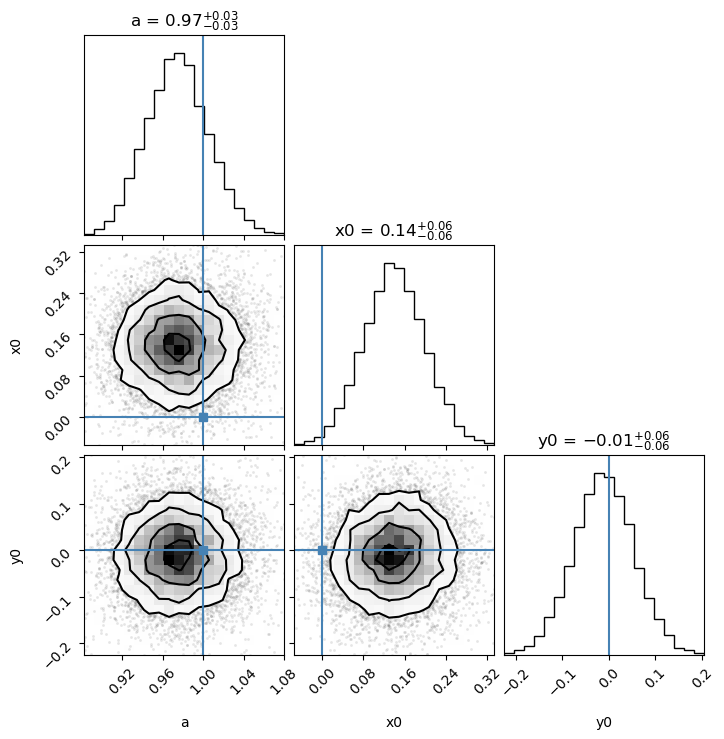

In [22]:
expdata = make_exponential(*truths, n)

LOG2 = 1

samplerplum_expdata, samplerexp_expdata, _, _ = infer_both(expdata, priors, truths, pool=4)
bf1 = (samplerplum_expdata.log_z - samplerexp_expdata.log_z)/np.log(10)

LOG2 = np.log(2)

samplerplum_expdata, samplerexp_expdata, _, _ = infer_both(expdata, priors, truths, pool=4)
bf2 = (samplerplum_expdata.log_z - samplerexp_expdata.log_z)/np.log(10)

bf1, bf2 

If we don't have that factor-of-2, the plummer is *strongly favored no matter what the data are*, which is clearly wrong...